In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# pip install --upgrade pip

In [12]:
# pip install --upgrade matplotlib

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-processing." data-toc-modified-id="Data-processing.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data processing.</a></span></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span></li><li><span><a href="#Work-day-analisys:-IN_time,-OUT_time-and-workday-duration." data-toc-modified-id="Work-day-analisys:-IN_time,-OUT_time-and-workday-duration.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Work day analisys: IN_time, OUT_time and workday duration.</a></span></li><li><span><a href="#Final-report" data-toc-modified-id="Final-report-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Final report</a></span></li></ul></div>

Find Revit top users (package licenses)

In [13]:
# pip install missingno

In [14]:
import pandas as pd
import numpy as np

import warnings
import math

from scipy.spatial.distance import pdist, squareform

from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# import uuid
import missingno as msno

import hashlib

import os

### Data processing.

In [15]:
folder_path = r"/content/drive/MyDrive/HPP/Lisences/log file_uninterrupted"

In [17]:
warnings.filterwarnings("ignore")

info_list = []

files = os.listdir(folder_path)
for file_name in files:
    if file_name.endswith(".log"): # Change this to match the extension of your files
        file_path = os.path.join(folder_path, file_name)
        # Try opening the file with 'latin-1' encoding
        with open(file_path, "r", encoding="latin-1") as file:
            for line in file:
                if line.find('TIMESTAMP') != -1 or line.find('IN:') != -1 or line.find('OUT:') != -1 or line.find('DENIED:') != -1 or line.find('IBM PC') != -1:
                    info_list.append(line) # Unite all important lines in one schedule
# info_list[-50:]

In [18]:
temp_list = []
result = []
for item in info_list:
    if 'TIMESTAMP' in item or 'IBM PC' in item:
        if temp_list:
            result.append(temp_list)
            temp_list = []
    if temp_list or 'TIMESTAMP' or 'IBM PC' in item:
        temp_list.append(item)
if temp_list:
    result.append(temp_list)

# result[20]

In [19]:
new_data = []
for item_list in result:
    if 'TIMESTAMP' in item_list[0]:
        date = item_list[0].split('TIMESTAMP')[-1]
    elif '(IBM PC)' in item_list[0]:
        date = item_list[0].split('(IBM PC)')[-1]
    new_result = []
    for line in item_list:
        new_line = line.replace(line, date +' '+ line)
        new_result.append(new_line)
    del new_result[0]
    if new_result != []:
        new_data.append(new_result)

In [20]:
# new_data[len(new_data)-2]

In [21]:
len(new_data)

1501

In [22]:
import itertools
data_for_df = itertools.chain.from_iterable(new_data)

Removing info about package and Autocad.

In [23]:
data_for_df_clean = []
for line in data_for_df:
    if '_T_F' not in line:
        if 'SERVER-OUT' not in line:
            data_for_df_clean.append(line)

In [24]:
data = pd.DataFrame(data_for_df_clean)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152030 entries, 0 to 152029
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       152030 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [25]:
data

,0
0,"(5/23/2023)\n 7:46:09 (adskflex) OUT: ""87393..."
1,"(5/23/2023)\n 7:46:26 (adskflex) OUT: ""87443..."
2,"(5/23/2023)\n 7:47:27 (adskflex) OUT: ""87443..."
3,"(5/23/2023)\n 7:47:40 (adskflex) IN: ""87393A..."
4,"(5/23/2023)\n 7:47:58 (adskflex) OUT: ""87393..."
...,...
152025,"2/29/2024\n 14:40:46 (adskflex) OUT: ""87443RV..."
152026,"2/29/2024\n 14:41:52 (adskflex) IN: ""87443RVT..."
152027,"2/29/2024\n 14:42:09 (adskflex) IN: ""87443RVT..."
152028,"2/29/2024\n 14:42:11 (adskflex) IN: ""87443RVT..."


Checking DF for separators.

In [26]:
warnings.filterwarnings("ignore")

print(data[0].str.contains('(adskflex)').unique())
print(data[0].str.contains('"').unique())
print(data[0].str.contains('@').unique())

[ True]
[ True]
[ True]


In [27]:
data['date_time'] = data[0].str.split('(adskflex)').str[0]
data['temp'] = data[0].str.split('(adskflex)').str[2]
data['status'] = data['temp'].str.split('"').str[0]
data['license'] = data['temp'].str.split('"').str[1]
data['temp_1'] = data['temp'].str.split('"').str[2]
data['name'] = data['temp_1'].str.split('@').str[0]
data['temp_2'] = data['temp_1'].str.split('@').str[1]
data['location'] = data['temp_2'].str.split(' ').str[0]
data['additional'] = data['temp_2'].str.split(' ').str[2]
data['status'] = data['status'].str.split(' ').str[1]
data['status'] = data['status'].str.split(':').str[0]
data['date_time'] = data['date_time'].str.replace('(', '')
data['date_time'] = data['date_time'].str.replace(')', '')
data['license'] = data['license'].str.split('_').str[-2]

In [28]:
# data.head(20)

In [29]:
data = data.drop(columns=[0, 'temp', 'temp_1', 'temp_2'])

Cleaning strings.

In [30]:
data['date_time'] = data['date_time'].replace('\n ', 'T', regex=True)

In [31]:
warnings.filterwarnings("ignore")
import re

data['additional'] = data['additional'].str.strip()
data['additional'] = data['additional'].str.replace(re.escape('(INACTIVE)'), 'inactive')
data['additional'] = data['additional'].str.replace(re.escape('(Licensed'), 'licensed number reached')

In [32]:
data['date_time']

,date_time
0,5/23/2023T 7:46:09
1,5/23/2023T 7:46:26
2,5/23/2023T 7:47:27
3,5/23/2023T 7:47:40
4,5/23/2023T 7:47:58
...,...
152025,2/29/2024T14:40:46
152026,2/29/2024T14:41:52
152027,2/29/2024T14:42:09
152028,2/29/2024T14:42:11


In [33]:
data['date_time'] = data['date_time'].str.replace(r'\s+', '', regex=True)

In [34]:
# data.iloc[100:120]

In [35]:
data.date_time = pd.to_datetime(data.date_time, format='%m/%d/%YT%H:%M:%S')

In [36]:
# data

In [37]:
data['day_of_week'] = data['date_time'].dt.strftime('%a')
data['day'] = data['date_time'].dt.strftime('%d')
data['month'] = data['date_time'].dt.strftime('%b')
data['date'] = data['date_time'].dt.date

data['status'] = data['status'].str.lower()
data['name'] = data['name'].str.lower()

data['status'] = data['status'].str.strip()
data['additional'] = data['additional'].str.strip()

data = data.replace(r'^\s*$', np.nan, regex=True)

In [38]:
data['time'] = data['date_time'].dt.time
data['hours'] = data['date_time'].dt.hour

In [39]:
# data.reset_index(drop=True).head()

In [40]:
data['date_time']

,date_time
0,2023-05-23 07:46:09
1,2023-05-23 07:46:26
2,2023-05-23 07:47:27
3,2023-05-23 07:47:40
4,2023-05-23 07:47:58
...,...
152025,2024-02-29 14:40:46
152026,2024-02-29 14:41:52
152027,2024-02-29 14:42:09
152028,2024-02-29 14:42:11


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152030 entries, 0 to 152029
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date_time    152030 non-null  datetime64[ns]
 1   status       152030 non-null  object        
 2   license      152030 non-null  object        
 3   name         152030 non-null  object        
 4   location     152030 non-null  object        
 5   additional   69843 non-null   object        
 6   day_of_week  152030 non-null  object        
 7   day          152030 non-null  object        
 8   month        152030 non-null  object        
 9   date         152030 non-null  object        
 10  time         152030 non-null  object        
 11  hours        152030 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(10)
memory usage: 13.3+ MB


In [42]:
# data

In [43]:
name_id = data['name'].unique()
name_id = pd.DataFrame(name_id)
name_id[0].unique()
name_id['id'] = name_id[0].apply(lambda x: hashlib.md5(str(x).encode()).hexdigest()[:8])
name_id.columns = ['name', 'id']
data = pd.merge(data, name_id, on='name')

In [44]:
# data[(data['id'] == 'b3b10783') & (data['month'] == 'Jun')]

In [45]:
data = data.drop(columns=['name'])

In [46]:
data.head(20)

,date_time,status,license,location,additional,day_of_week,day,month,date,time,hours,id
0,2023-05-23 07:46:09,out,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:46:09,7,66444989
1,2023-05-23 07:46:26,out,2021,DG99M63,NaN,Tue,23,May,2023-05-23,07:46:26,7,e6912c00
2,2023-05-23 07:47:27,out,2021,74TT2T3,NaN,Tue,23,May,2023-05-23,07:47:27,7,34beb027
3,2023-05-23 07:47:40,in,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:47:40,7,66444989
4,2023-05-23 07:47:58,out,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:47:58,7,66444989
5,2023-05-23 07:49:32,in,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:49:32,7,66444989
6,2023-05-23 07:51:46,out,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:51:46,7,66444989
7,2023-05-23 07:58:58,out,2021,1T39M63,NaN,Tue,23,May,2023-05-23,07:58:58,7,f1ad8b33
8,2023-05-23 08:05:10,out,2021,GWK8M63,NaN,Tue,23,May,2023-05-23,08:05:10,8,941ffeb6
9,2023-05-23 08:05:29,out,2021,GWK8M63,NaN,Tue,23,May,2023-05-23,08:05:29,8,941ffeb6


In [47]:
# print('As we do not have continuous data on licenses, the data below does not represent the complete information')
# print()
# for i, j in zip(data[data['status'] == 'out'].groupby('date')['hours'].max(),
#                 data[data['status'] == 'in'].groupby('date')['hours'].max()):
#     print(f'{i}, {j}')

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152030 entries, 0 to 152029
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date_time    152030 non-null  datetime64[ns]
 1   status       152030 non-null  object        
 2   license      152030 non-null  object        
 3   location     152030 non-null  object        
 4   additional   69843 non-null   object        
 5   day_of_week  152030 non-null  object        
 6   day          152030 non-null  object        
 7   month        152030 non-null  object        
 8   date         152030 non-null  object        
 9   time         152030 non-null  object        
 10  hours        152030 non-null  int32         
 11  id           152030 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(10)
memory usage: 13.3+ MB


### Data analysis

Total count of people active in the table

In [49]:
len(data['id'].unique())

221

In [50]:
data_new = data[(data['status'] == 'out') | (data['status'] == 'denied')]
data_new.reset_index(drop=True).head(20)

,date_time,status,license,location,additional,day_of_week,day,month,date,time,hours,id
0,2023-05-23 07:46:09,out,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:46:09,7,66444989
1,2023-05-23 07:46:26,out,2021,DG99M63,NaN,Tue,23,May,2023-05-23,07:46:26,7,e6912c00
2,2023-05-23 07:47:27,out,2021,74TT2T3,NaN,Tue,23,May,2023-05-23,07:47:27,7,34beb027
3,2023-05-23 07:47:58,out,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:47:58,7,66444989
4,2023-05-23 07:51:46,out,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:51:46,7,66444989
5,2023-05-23 07:58:58,out,2021,1T39M63,NaN,Tue,23,May,2023-05-23,07:58:58,7,f1ad8b33
6,2023-05-23 08:05:10,out,2021,GWK8M63,NaN,Tue,23,May,2023-05-23,08:05:10,8,941ffeb6
7,2023-05-23 08:05:29,out,2021,GWK8M63,NaN,Tue,23,May,2023-05-23,08:05:29,8,941ffeb6
8,2023-05-23 08:09:25,out,2021,GWK8M63,NaN,Tue,23,May,2023-05-23,08:09:25,8,941ffeb6
9,2023-05-23 08:09:25,out,2021,GWK8M63,NaN,Tue,23,May,2023-05-23,08:09:25,8,941ffeb6


In [51]:
data_new1 = data_new.drop_duplicates(subset=['date', 'id','status'])
# data_new1 = data_new1[data_new1['day'] != '31']
data_new1 = data_new1.drop(columns=['date_time'])
data_new1.reset_index()
data_new1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24252 entries, 0 to 152018
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   status       24252 non-null  object
 1   license      24252 non-null  object
 2   location     24252 non-null  object
 3   additional   10527 non-null  object
 4   day_of_week  24252 non-null  object
 5   day          24252 non-null  object
 6   month        24252 non-null  object
 7   date         24252 non-null  object
 8   time         24252 non-null  object
 9   hours        24252 non-null  int32 
 10  id           24252 non-null  object
dtypes: int32(1), object(10)
memory usage: 2.1+ MB


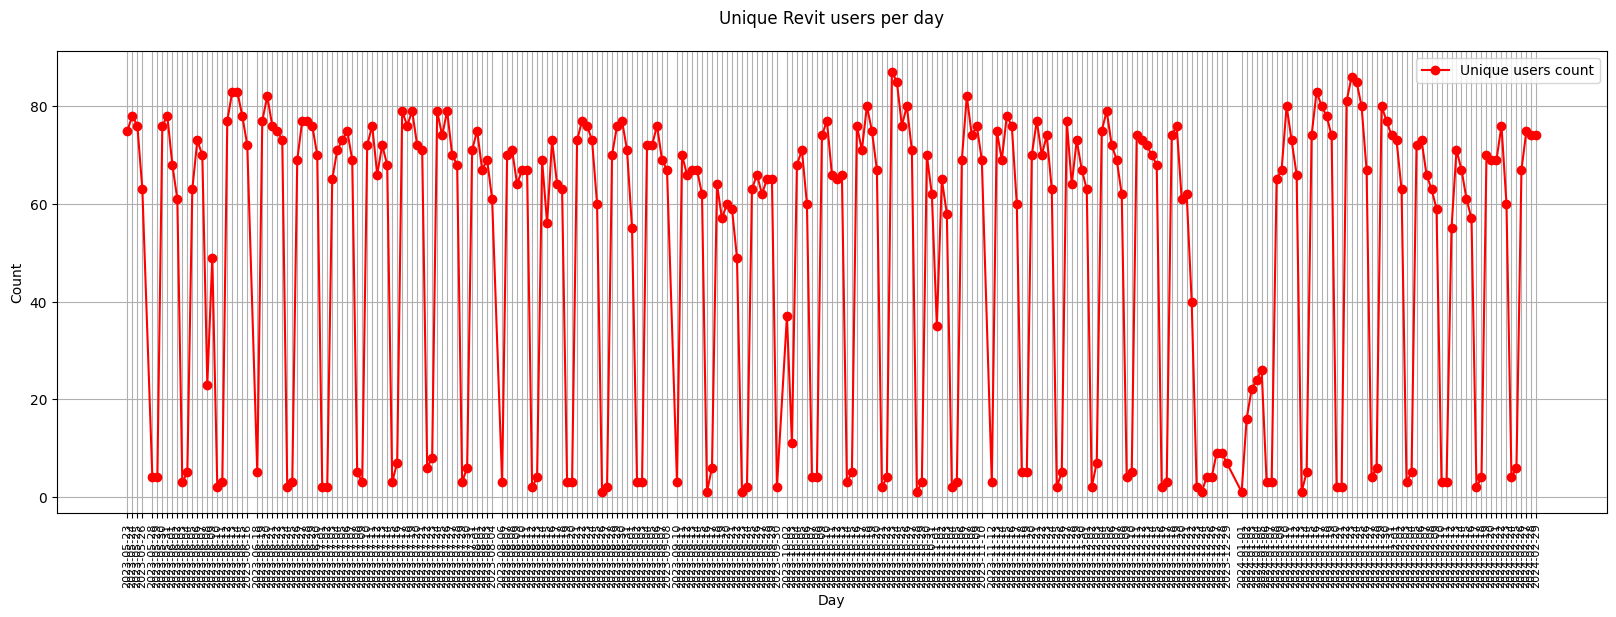

In [52]:
in_entrances = data_new1[data_new1['status'] == 'out'].pivot_table(index=['date'], values='id', aggfunc='count')

in_entrances.plot(
    grid=True,
    figsize=(20, 6),
    rot=90,
    fontsize=10,
    style='o-',
    color='r',
#     legend=True,
#     label='Unique users count'
)

# Add plot title, labels, and other formatting
plt.title('Unique Revit users per day', pad=20)
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(in_entrances.index, fontsize=8)  # Update x-axis ticks
plt.legend(loc='upper left')
plt.legend(['Unique users count'])
plt.show()

In [53]:
names = []
times = []
for name, count in data_new1[data_new1['status'] == 'out'].groupby('id'):
    names.append(name)
    times.append(len(count))
#     print('{} occurs {} time(s)'.format(name, len(count)))

name_count_data = pd.DataFrame([names, times])
name_count_data = name_count_data.T
name_count_data.columns = ['id', 'count']
name_count_data['count'] = pd.to_numeric(name_count_data['count'])
print(name_count_data.info())
name_count_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      221 non-null    object
 1   count   221 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ KB
None


,id,count
0,01541ef7,44
1,049f5937,116
2,05438ec8,4
3,05f07e59,147
4,0631c7d8,1


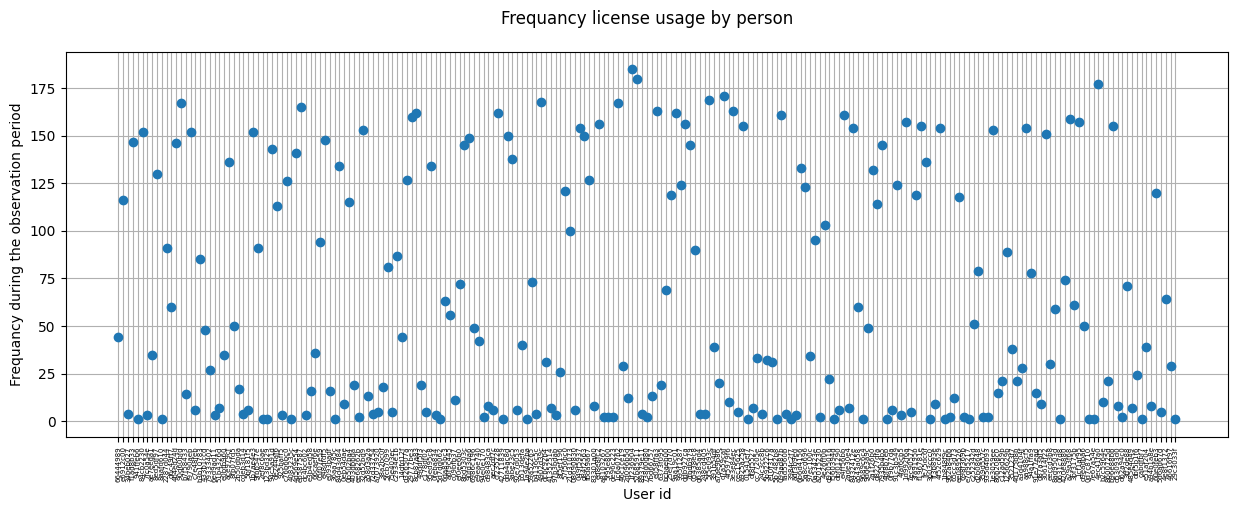

In [54]:
ax1 = data_new1[data_new1['status'] == 'out'].groupby('id')['id'].count().plot(
    rot=90,
    figsize=(15, 5),
    y='id',
    style='o',
    grid=True
);
ax1.set_title('Frequancy license usage by person', pad = 20);
ax1.set_xlabel('User id');
ax1.set_ylabel('Frequancy during the observation period');
ax1.set_xticks(range(len(data_new1['id'].unique())))  # Set x-ticks positions
ax1.set_xticklabels(data_new1['id'].unique(), rotation=90, fontsize=5)  # Set x-tick labels
plt.show()

In [55]:
li_count = data_new1[data_new1['status'] == 'out'].groupby('id')['status'].count()
li_count = pd.DataFrame(li_count)
li_count.columns = ['count']
li_count[['count']].sort_values('count', ascending=False).head(10)

,count
id,
84cb2230,185
84d43d84,180
e6912c00,177
941ffeb6,171
925baff5,169
66444989,168
7fc0a54e,167
123bd329,167
34beb027,165


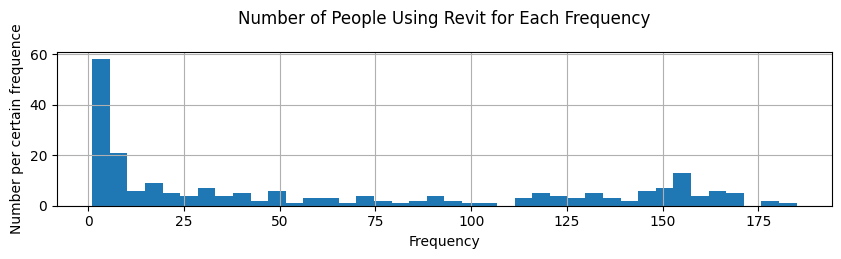

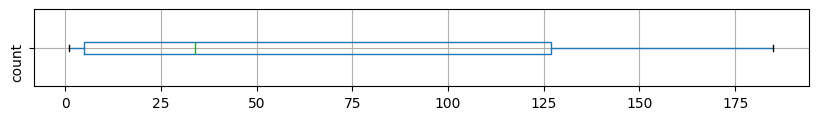

In [56]:
ax2 = name_count_data['count'].hist(
    bins=40,
    figsize=(10, 2),
);
ax2.set_title('Number of People Using Revit for Each Frequency', pad = 20);
ax2.set_xlabel('Frequency');
ax2.set_ylabel('Number per certain frequence');
plt.show()
name_count_data.boxplot(column='count' ,figsize=(10, 1), vert=False, rot = 90)
plt.show()

In [57]:
name_count_data['count'].describe()

,count
count,221.000000
mean,62.104072
std,62.321111
min,1.000000
25%,5.000000
50%,34.000000
75%,127.000000
max,185.000000


In [58]:
mean_days_count = name_count_data['count'].describe()['50%']
mean_days_count

34.0

The decision about barrier value should be based on several parameters, and that should be considered by license team.

Price of entries per month.

In [59]:
year_price = 3303
print('price of 1 entrance if you do 5 entrances a month is: {} euro'.format(3303/12/5))
print('price of 1 entrance if you do 10 entrances a month is: {} euro'.format(3303/12/10))
print('price of 1 entrance if you do 15 entrances a month is: {} euro'.format(3303/12/15))
print('price of 1 entrance if you do 20 entrances a month is: {} euro'.format(3303/12/20))

price of 1 entrance if you do 5 entrances a month is: 55.05 euro
price of 1 entrance if you do 10 entrances a month is: 27.525 euro
price of 1 entrance if you do 15 entrances a month is: 18.35 euro
price of 1 entrance if you do 20 entrances a month is: 13.7625 euro


### Work day analisys: IN_time, OUT_time and workday duration.

In [60]:
# Excluding weekends

data_n = data.copy()
data_n['date_time'] = data_n['date_time'].dt.round('min')
data_n = data_n[(data_n['day_of_week'] != 'Sat') & (data_n['day_of_week'] != 'Sun')]

In [61]:
# Drop duplicates

data_n = data_n.drop_duplicates(subset=['date_time', 'id','status', 'license'])

In [62]:
# Check the dates we are working with

data_n['date'].unique()

array([datetime.date(2023, 5, 23), datetime.date(2023, 5, 24),
       datetime.date(2023, 5, 25), datetime.date(2023, 5, 26),
       datetime.date(2023, 5, 29), datetime.date(2023, 5, 30),
       datetime.date(2023, 5, 31), datetime.date(2023, 6, 1),
       datetime.date(2023, 6, 2), datetime.date(2023, 6, 5),
       datetime.date(2023, 6, 6), datetime.date(2023, 6, 7),
       datetime.date(2023, 6, 8), datetime.date(2023, 6, 9),
       datetime.date(2023, 6, 12), datetime.date(2023, 6, 13),
       datetime.date(2023, 6, 14), datetime.date(2023, 6, 15),
       datetime.date(2023, 6, 16), datetime.date(2023, 6, 19),
       datetime.date(2023, 6, 20), datetime.date(2023, 6, 21),
       datetime.date(2023, 6, 22), datetime.date(2023, 6, 23),
       datetime.date(2023, 6, 26), datetime.date(2023, 6, 27),
       datetime.date(2023, 6, 28), datetime.date(2023, 6, 29),
       datetime.date(2023, 6, 30), datetime.date(2023, 7, 3),
       datetime.date(2023, 7, 4), datetime.date(2023, 7, 5),
  

In [63]:
day_name = []
data_in = []
data_out = []
day_name_out = []

for date in data_n['date'].unique():
    day_name_t = []
    data_in_t = []
    data_out_t = []
    day_name_out_t = []
    day_data = data_n[data_n['date'] == date]
    for index in day_data.index:
        if day_data['status'][index] == 'out' and day_data['id'][index] not in day_name_t:
            day_name_t.append(day_data['id'][index])
            data_in_t.append(day_data['date_time'][index])
    day_name.append(day_name_t)
    data_in.append(data_in_t)
    reverse = day_data.iloc[::-1]
    reverse = reverse.reset_index()
    for index in reverse.index:
        if reverse['status'][index] == 'in' and reverse['id'][index] not in day_name_out_t:
            day_name_out_t.append(reverse['id'][index])
            data_out_t.append(reverse['date_time'][index])
    day_name_out.append(day_name_out_t)
    data_out.append(data_out_t)

print(len(data_in))
print(len(day_name))
print(len(data_out))
print(len(day_name_out))

203
203
203
203


In [64]:
df_in_list = []

for index in range(0, len(data_in)):
    df = pd.DataFrame([day_name[index], data_in[index]])
    df = df.T
    df.columns = ['id', 'time_in']
    df_in_list.append(df)

len(df_in_list)
df_in_list[15]

,id,time_in
0,90fd3da6,2023-06-13 06:51:00
1,66444989,2023-06-13 07:21:00
2,433b1ccd,2023-06-13 07:24:00
3,14dfd12f,2023-06-13 07:34:00
4,79333402,2023-06-13 08:00:00
...,...,...
78,4f5979f6,2023-06-13 14:14:00
79,ef0ee6b0,2023-06-13 14:30:00
80,391b54df,2023-06-13 16:32:00
81,0feba834,2023-06-13 21:13:00


In [65]:
df_out_list = []

for index in range(0, len(data_out)):
    df = pd.DataFrame([day_name_out[index], data_out[index]])
    df = df.T
    df.columns = ['id', 'time_out']
    df_out_list.append(df)

len(df_out_list)
df_out_list[15]

,id,time_out
0,0feba834,2023-06-13 21:13:00
1,dcbc92b4,2023-06-13 20:08:00
2,9fbb547e,2023-06-13 19:38:00
3,34beb027,2023-06-13 19:36:00
4,4d569e54,2023-06-13 19:24:00
...,...,...
77,7bd66757,2023-06-13 13:32:00
78,738d0d80,2023-06-13 12:48:00
79,a7ae9b86,2023-06-13 11:50:00
80,a7073920,2023-06-13 11:13:00


In [67]:
df_in_out_merge_list = []

for index in range(0, len(df_in_list)):
    merged_df = pd.merge(df_in_list[index], df_out_list[index], on='id')
    merged_df = merged_df.query('time_out > time_in')
    merged_df = merged_df.reset_index(drop=True)

    # Convert 'time_in' and 'time_out' to datetime objects
    merged_df['time_in'] = pd.to_datetime(merged_df['time_in'])
    merged_df['time_out'] = pd.to_datetime(merged_df['time_out'])

    merged_df['duration'] = merged_df['time_out'] - merged_df['time_in']
    merged_df['d_hours'] = merged_df['duration'] / pd.Timedelta(hours=1)
    merged_df['date'] = merged_df['time_in'].dt.date
    merged_df['in_hours'] = merged_df['time_in'].dt.time
    merged_df['out_hours'] = merged_df['time_out'].dt.time
    df_in_out_merge_list.append(merged_df)

In [68]:
df_in_out_merge_list[5]

,id,time_in,time_out,duration,d_hours,date,in_hours,out_hours
0,b3b10783,2023-05-30 06:04:00,2023-05-30 07:22:00,0 days 01:18:00,1.300000,2023-05-30,06:04:00,07:22:00
1,42711839,2023-05-30 07:59:00,2023-05-30 15:54:00,0 days 07:55:00,7.916667,2023-05-30,07:59:00,15:54:00
2,c09bfb37,2023-05-30 08:09:00,2023-05-30 19:57:00,0 days 11:48:00,11.800000,2023-05-30,08:09:00,19:57:00
3,7fc0a54e,2023-05-30 08:09:00,2023-05-30 18:19:00,0 days 10:10:00,10.166667,2023-05-30,08:09:00,18:19:00
4,dda4ac8d,2023-05-30 08:12:00,2023-05-30 16:32:00,0 days 08:20:00,8.333333,2023-05-30,08:12:00,16:32:00
...,...,...,...,...,...,...,...,...
71,aec2df7c,2023-05-30 14:05:00,2023-05-30 21:34:00,0 days 07:29:00,7.483333,2023-05-30,14:05:00,21:34:00
72,5f95e800,2023-05-30 14:43:00,2023-05-30 15:21:00,0 days 00:38:00,0.633333,2023-05-30,14:43:00,15:21:00
73,de96c223,2023-05-30 16:06:00,2023-05-30 16:10:00,0 days 00:04:00,0.066667,2023-05-30,16:06:00,16:10:00
74,49ddf5f3,2023-05-30 17:10:00,2023-05-30 17:57:00,0 days 00:47:00,0.783333,2023-05-30,17:10:00,17:57:00


In [69]:
count = 0
for df in df_in_out_merge_list:
    count += 1
    if not df.empty:  # Check if the DataFrame is not empty
        print(df['date'].iloc[0], df['duration'].median())
print('*****')
print('total days:',count)

2023-05-23 0 days 08:39:00
2023-05-24 0 days 08:33:00
2023-05-25 0 days 08:27:00
2023-05-26 0 days 08:04:00
2023-05-29 0 days 02:00:00
2023-05-30 0 days 08:19:30
2023-05-31 0 days 08:24:00
2023-06-01 0 days 08:10:30
2023-06-02 0 days 07:24:00
2023-06-05 0 days 08:22:00
2023-06-06 0 days 07:58:00
2023-06-07 0 days 07:59:30
2023-06-08 0 days 07:54:00
2023-06-09 0 days 07:42:00
2023-06-12 0 days 08:23:30
2023-06-13 0 days 08:31:00
2023-06-14 0 days 08:26:00
2023-06-15 0 days 08:37:00
2023-06-16 0 days 07:36:00
2023-06-19 0 days 08:15:00
2023-06-20 0 days 08:28:00
2023-06-21 0 days 08:33:00
2023-06-22 0 days 08:23:00
2023-06-23 0 days 07:58:00
2023-06-26 0 days 08:34:30
2023-06-27 0 days 08:02:00
2023-06-28 0 days 08:28:30
2023-06-29 0 days 08:10:00
2023-06-30 0 days 07:46:00
2023-07-03 0 days 08:38:00
2023-07-04 0 days 08:31:00
2023-07-05 0 days 08:54:00
2023-07-06 0 days 08:22:30
2023-07-07 0 days 07:28:00
2023-07-10 0 days 08:24:00
2023-07-11 0 days 08:13:00
2023-07-12 0 days 08:44:00
2



graphs and info for day 2023-05-23


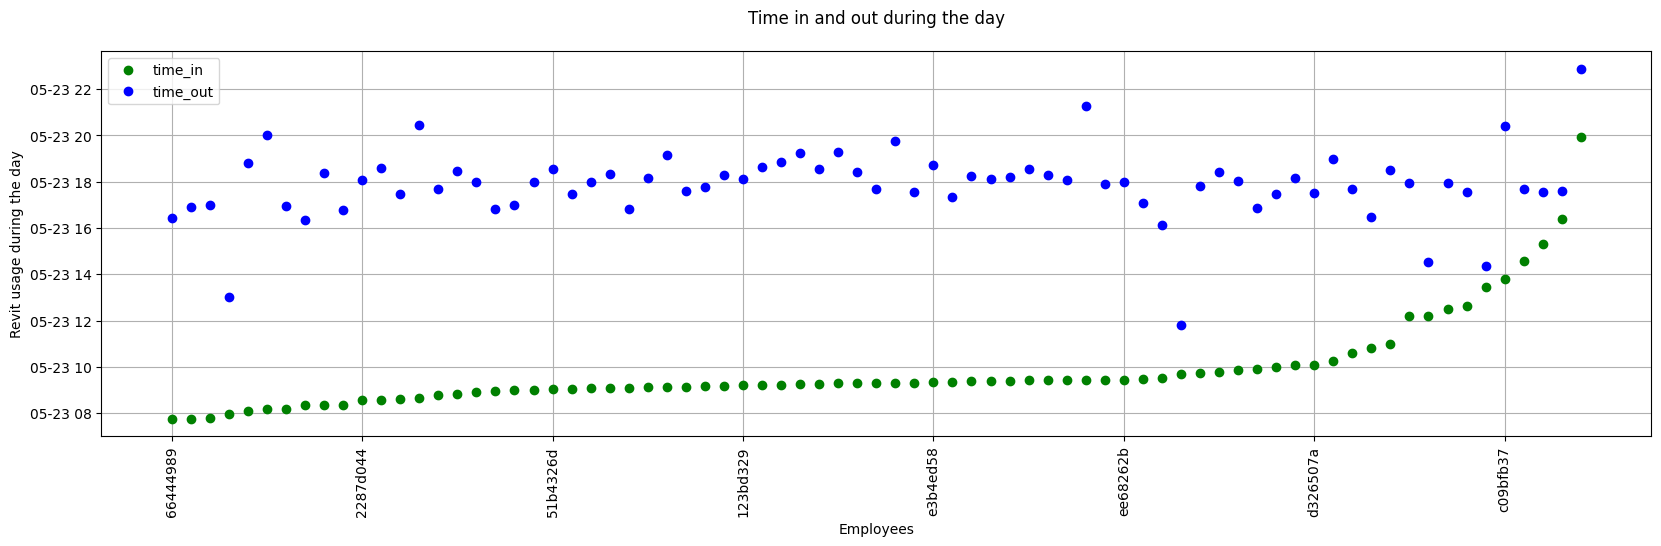

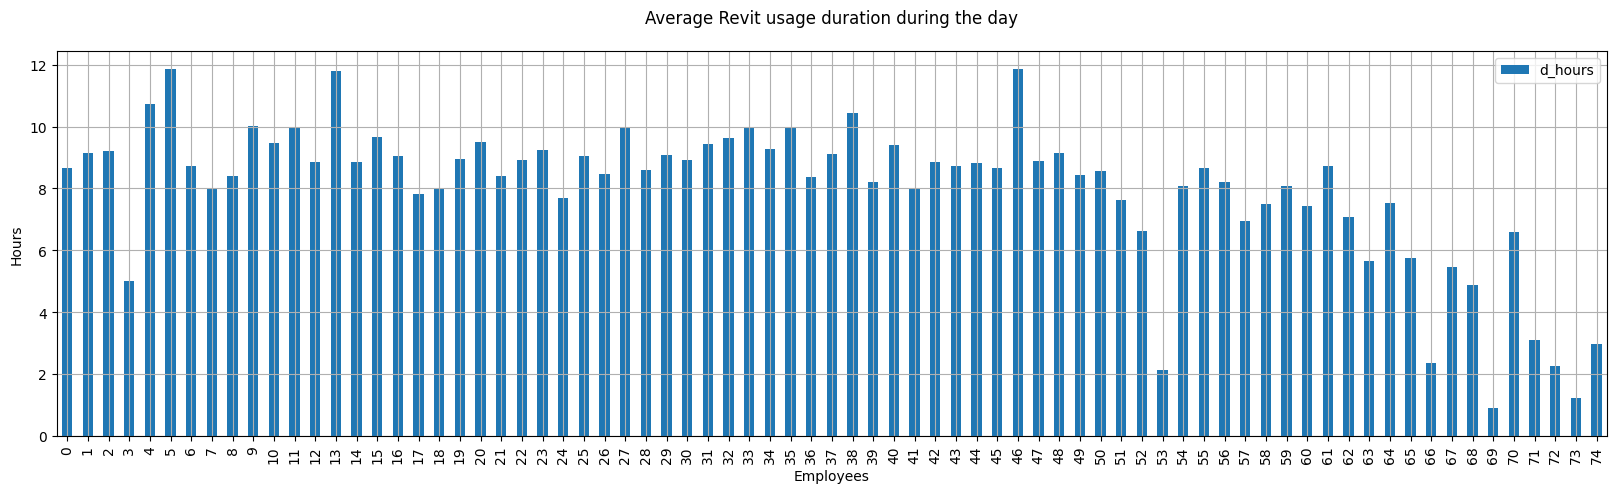


                        duration    d_hours
count                         75  75.000000
mean             0 days 07:59:44   7.995556
std    0 days 02:19:39.567814437   2.327658
min              0 days 00:54:00   0.900000
25%              0 days 07:34:30   7.575000
50%              0 days 08:39:00   8.650000
75%              0 days 09:10:30   9.175000
max              0 days 11:51:00  11.850000


graphs and info for day 2023-05-24


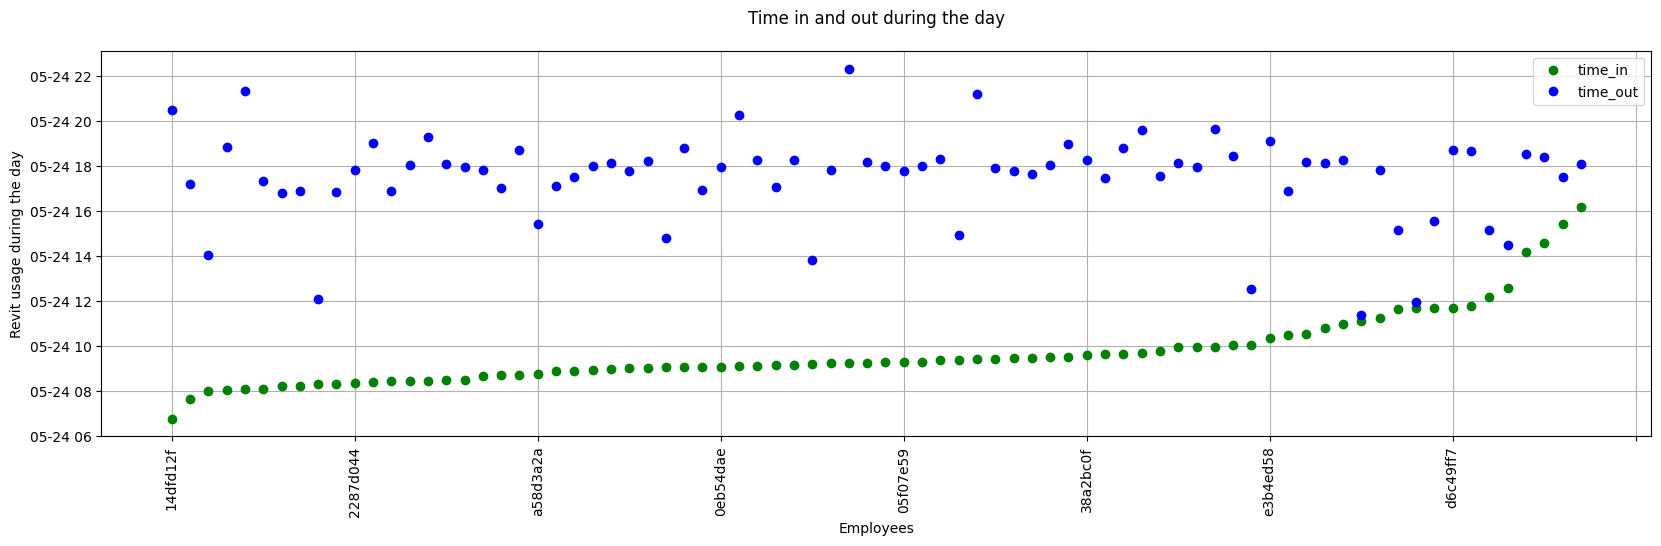

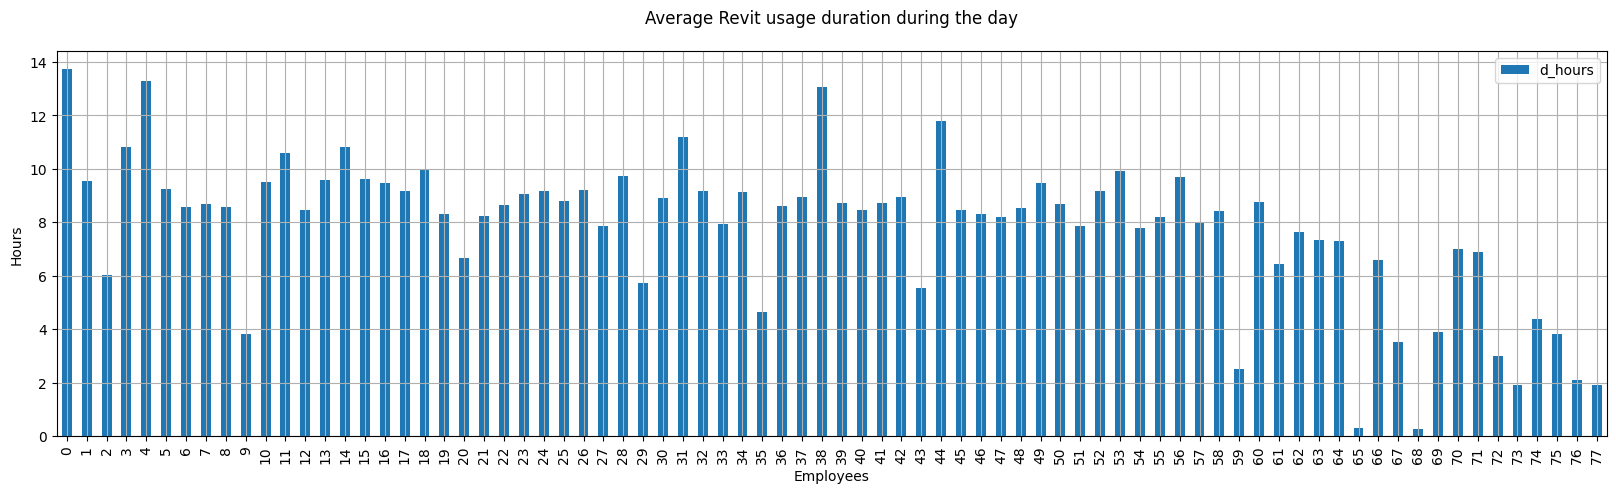


                        duration    d_hours
count                         78  78.000000
mean   0 days 07:49:34.615384615   7.826282
std    0 days 02:44:57.449585206   2.749292
min              0 days 00:16:00   0.266667
25%              0 days 06:54:45   6.912500
50%              0 days 08:33:00   8.550000
75%              0 days 09:11:30   9.191667
max              0 days 13:43:00  13.716667


graphs and info for day 2023-05-25


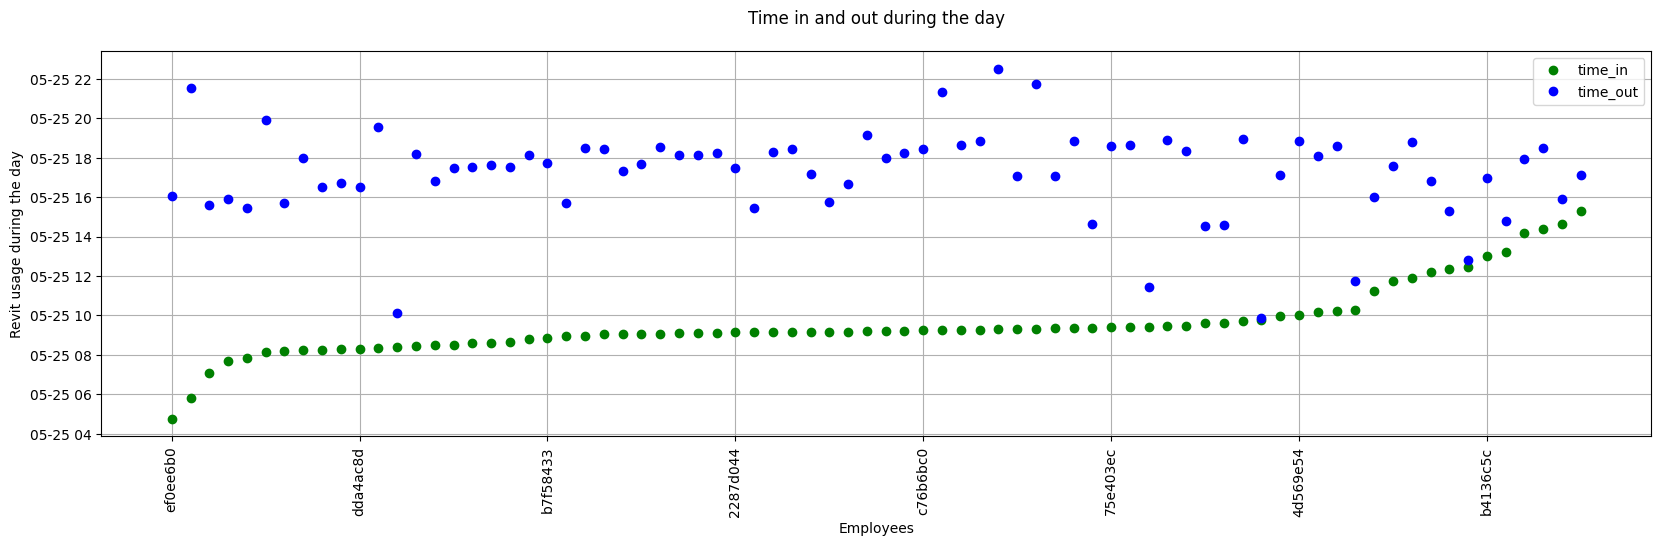

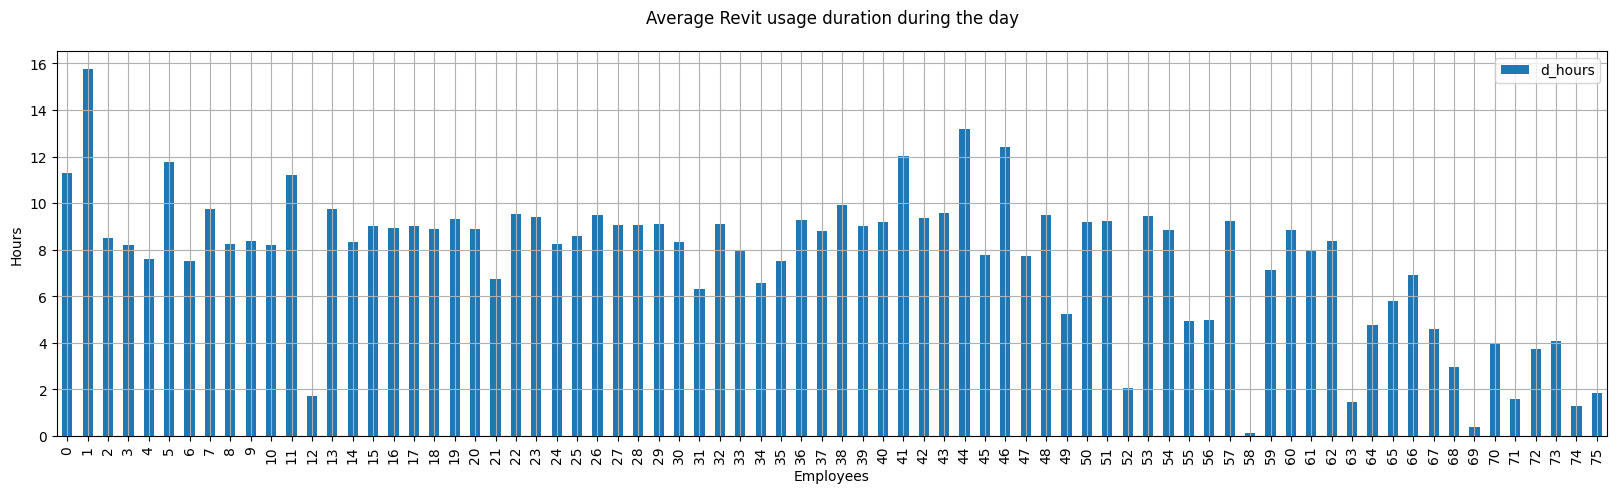


                        duration    d_hours
count                         76  76.000000
mean   0 days 07:39:26.842105263   7.657456
std    0 days 03:02:51.887253099   3.047746
min              0 days 00:07:00   0.116667
25%              0 days 06:29:15   6.487500
50%              0 days 08:27:00   8.450000
75%              0 days 09:15:30   9.258333
max              0 days 15:45:00  15.750000


In [71]:
for df in df_in_out_merge_list[:3]:
    if df['duration'].mean() > pd.Timedelta(hours=7):
        print('')
        print('')
        print('graphs and info for day {}'.format(df['date'][0]))

        df.sort_values(by='time_in').plot(
        y=['time_in', 'time_out'],
        x='id',
        style='o',
        color=['g', 'b'],
        figsize=(20, 5),
        grid=True,
        rot=90)
        plt.title('Time in and out during the day', pad = 20)
        plt.xlabel('Employees')
        plt.ylabel('Revit usage during the day')
        plt.show();

        df[['d_hours']].plot(
        kind='bar',
        grid=True,
        figsize=(20, 5));
        plt.title('Average Revit usage duration during the day', pad = 20)
        plt.xlabel('Employees')
        plt.ylabel('Hours');
        plt.show()

        print('')
        print(df.iloc[:, 3:].describe())

In [72]:
describe_info = []
df_in_out_merge = df_in_out_merge_list.copy()
for df in df_in_out_merge:
    if df['duration'].median() > pd.Timedelta(hours=7): # we could use df['duration'].mean() as well, but we cut more days
        df_ = df.describe()
        describe_info.append(df_)

In [73]:
print(f'We will select only the data for the {len(describe_info)} days that have an average time of 7 hours or more for further analysis.')

We will select only the data for the 196 days that have an average time of 7 hours or more for further analysis.


In [74]:
describe_info_new = []
for df in describe_info:
    new_df = df['d_hours'].describe()
    describe_info_new.append(new_df)

In [75]:
describe_info_ = pd.concat(describe_info_new, join='outer', axis=1)
describe_info_

,d_hours,d_hours,d_hours,d_hours,d_hours,d_hours,d_hours,d_hours,d_hours,d_hours,...,d_hours,d_hours,d_hours,d_hours,d_hours,d_hours,d_hours,d_hours,d_hours,d_hours
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,15.434152,15.901634,15.845963,13.801374,15.533080,15.453860,14.468890,12.936063,13.817336,14.905053,...,13.335963,12.680788,14.583148,14.745433,14.404664,15.088303,13.642011,14.082842,15.672107,15.471154
std,24.337681,25.420755,24.734164,19.913073,24.780918,24.081576,22.031094,19.771623,20.256426,23.827790,...,19.338644,18.423535,22.713850,22.303975,22.353477,24.102730,19.244485,21.663406,24.333447,24.011536
min,0.900000,0.266667,0.116667,0.116667,0.066667,0.016667,0.033333,0.016667,0.400000,0.050000,...,0.033333,0.066667,0.016667,0.016667,0.200000,0.583333,0.016667,0.633333,0.600000,0.150000
25%,6.263164,5.871698,5.627562,5.644414,5.212980,5.189590,4.975894,4.459216,5.426835,4.856453,...,4.318662,4.329559,5.722813,6.144550,5.968085,5.502958,5.843744,5.549671,6.175354,6.271166
50%,8.322778,8.188141,8.053728,7.637500,7.852193,7.969595,7.769608,6.850820,7.803175,7.490639,...,7.554444,6.689035,7.689048,7.934300,7.932488,7.630631,7.845139,7.794527,8.208556,8.265203
75%,9.843750,10.322917,10.881250,10.333333,10.558333,10.818750,10.487500,9.391667,10.014583,10.137500,...,10.396875,10.020833,9.923958,10.158333,9.691667,9.860417,10.405208,9.627083,10.443750,10.448958
max,75.000000,78.000000,76.000000,62.000000,76.000000,74.000000,68.000000,61.000000,63.000000,73.000000,...,60.000000,57.000000,70.000000,69.000000,69.000000,74.000000,60.000000,67.000000,75.000000,74.000000


In [76]:
# describe_info = pd.concat(describe_info, join='outer', axis=1)
describe_info = describe_info_.T
describe_info = describe_info.reset_index()
describe_info = describe_info.drop(columns='index')

In [77]:
describe_info.head(30)

,count,mean,std,min,25%,50%,75%,max
0,8.0,15.434152,24.337681,0.900000,6.263164,8.322778,9.843750,75.0
1,8.0,15.901634,25.420755,0.266667,5.871698,8.188141,10.322917,78.0
2,8.0,15.845963,24.734164,0.116667,5.627562,8.053728,10.881250,76.0
3,8.0,13.801374,19.913073,0.116667,5.644414,7.637500,10.333333,62.0
4,8.0,15.533080,24.780918,0.066667,5.212980,7.852193,10.558333,76.0
5,8.0,15.453860,24.081576,0.016667,5.189590,7.969595,10.818750,74.0
6,8.0,14.468890,22.031094,0.033333,4.975894,7.769608,10.487500,68.0
7,8.0,12.936063,19.771623,0.016667,4.459216,6.850820,9.391667,61.0
8,8.0,13.817336,20.256426,0.400000,5.426835,7.803175,10.014583,63.0
9,8.0,14.905053,23.827790,0.050000,4.856453,7.490639,10.137500,73.0


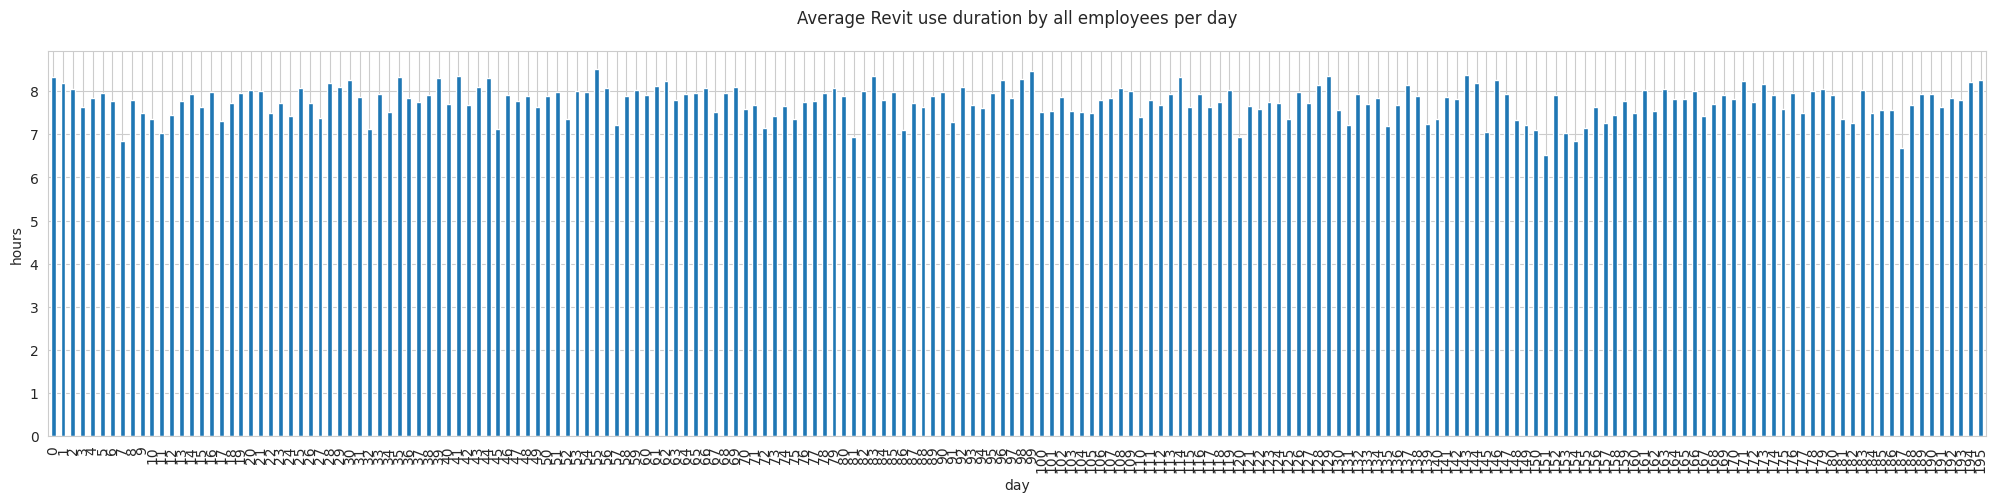

In [120]:
describe_info['50%'].plot(kind='bar',
                          figsize=(25, 5),
                          grid = True
);
plt.title('Average Revit use duration by all employees per day', pad = 20)
plt.xlabel('day')
plt.ylabel('hours')
plt.show();

In [128]:
describe_info['number'] = describe_info.index

describe = describe_info[['number','50%']]
describe

,number,50%
0,0,8.322778
1,1,8.188141
2,2,8.053728
3,3,7.637500
4,4,7.852193
...,...,...
191,191,7.630631
192,192,7.845139
193,193,7.794527
194,194,8.208556


### Final report

In [102]:
id_duration = []

for df in df_in_out_merge_list:
    if df['duration'].mean() > pd.Timedelta(hours=7):
        new_df = df[['id', 'd_hours']]
        new_df.columns = ['id', str(df['date'][0])]
        id_duration.append(new_df)

In [103]:
import functools
from functools import reduce

id_duration_merged = reduce(lambda  left,right: pd.merge(left,right,on=['id'], how='outer'), id_duration)

In [104]:
id_duration_merged.head()

,id,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-30,2023-05-31,2023-06-01,2023-06-05,2023-06-06,...,2024-02-13,2024-02-14,2024-02-19,2024-02-20,2024-02-21,2024-02-22,2024-02-23,2024-02-26,2024-02-27,2024-02-28
0,01541ef7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,049f5937,NaN,NaN,NaN,NaN,8.983333,10.516667,9.083333,8.833333,10.166667,...,9.133333,8.900000,3.916667,NaN,NaN,9.283333,8.033333,9.05,NaN,NaN
2,05438ec8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,05f07e59,8.85,8.466667,8.866667,8.866667,10.150000,8.583333,8.733333,8.633333,9.016667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,08690830,NaN,NaN,NaN,NaN,5.650000,8.100000,NaN,8.833333,7.916667,...,7.200000,8.233333,8.200000,7.883333,7.933333,8.566667,7.266667,8.55,8.033333,8.05


In [105]:
id_duration_merged['median'] = id_duration_merged.iloc[:, 1:].median(skipna=True, axis=1)

In [106]:
id_duration_merged.iloc[:, 1: -3].head(10)
id_duration_merged.head(10)

,id,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-30,2023-05-31,2023-06-01,2023-06-05,2023-06-06,...,2024-02-14,2024-02-19,2024-02-20,2024-02-21,2024-02-22,2024-02-23,2024-02-26,2024-02-27,2024-02-28,median
0,01541ef7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.150000
1,049f5937,NaN,NaN,NaN,NaN,8.983333,10.516667,9.083333,8.833333,10.166667,...,8.900000,3.916667,NaN,NaN,9.283333,8.033333,9.050000,NaN,NaN,8.833333
2,05438ec8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.758333
3,05f07e59,8.850000,8.466667,8.866667,8.866667,10.150000,8.583333,8.733333,8.633333,9.016667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.616667
4,08690830,NaN,NaN,NaN,NaN,5.650000,8.100000,NaN,8.833333,7.916667,...,8.233333,8.200000,7.883333,7.933333,8.566667,7.266667,8.550000,8.033333,8.05,8.100000
5,099ad87b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.258333
6,0a53423e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.858333
7,0b502ba4,9.133333,9.150000,5.250000,NaN,0.633333,NaN,NaN,NaN,NaN,...,7.733333,2.933333,6.283333,5.700000,10.633333,NaN,8.583333,6.483333,5.60,5.541667
8,0d7c8710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.583333
9,0eb54dae,8.883333,8.900000,8.800000,9.016667,7.633333,7.883333,8.233333,5.933333,7.783333,...,NaN,6.200000,NaN,NaN,6.850000,NaN,7.466667,8.766667,4.35,8.083333


In [107]:
id_duration_merged
name_count_data
final_report = pd.merge(id_duration_merged, name_count_data, on=['id'], how='outer')
final_report.iloc[:, 1: -3] = final_report.iloc[:, 1: -3].round(decimals=2)

final_report = final_report.reindex(sorted(final_report.columns), axis=1)
final_report.insert(0, 'id', final_report.pop('id'))

final_report.loc[:, :'median'] = final_report.loc[:, :'median'].round(decimals=2)

In [108]:
final_report

,id,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-30,2023-05-31,2023-06-01,2023-06-05,2023-06-06,...,2024-02-19,2024-02-20,2024-02-21,2024-02-22,2024-02-23,2024-02-26,2024-02-27,2024-02-28,count,median
0,01541ef7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,7.15
1,049f5937,NaN,NaN,NaN,NaN,8.98,10.52,9.08,8.83,10.17,...,3.92,NaN,NaN,9.28,8.03,9.05,NaN,NaN,116,8.83
2,05438ec8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2.76
3,05f07e59,8.85,8.47,8.87,8.87,10.15,8.58,8.73,8.63,9.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147,8.62
4,0631c7d8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,f9790aeb,9.65,8.93,9.33,9.33,9.55,8.07,6.75,8.83,3.55,...,NaN,NaN,NaN,NaN,3.65,5.42,9.75,11.12,120,8.68
217,fad5560b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,3.11
218,fbda9a67,NaN,NaN,NaN,NaN,1.37,5.15,NaN,NaN,4.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,4.67
219,fe75dc6f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.07,6.83,NaN,4.87,6.15,7.95,6.07,7.70,29,6.15


In [109]:
# pip install openpyxl

In [110]:
# %%script echo skipping

final_report
final_report.to_excel(r'C:\Users\olga.poletkina\OneDrive - HPP Architekten GmbH\HPP_BIM_Work\23_01_26_license\report_id\final_report.xlsx', index=False)

In [111]:
final_report_top_users = final_report[(final_report['count'] >= mean_days_count) & (final_report['median'] >= 7)].reset_index(drop=True)

In [112]:
# %%script echo skipping

final_report_top_users
final_report_top_users.to_excel(r'C:\Users\olga.poletkina\OneDrive - HPP Architekten GmbH\HPP_BIM_Work\23_01_26_license\report_id\final_report_top_users.xlsx', index=False)

In [113]:
final_report_top_users.head()

,id,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-30,2023-05-31,2023-06-01,2023-06-05,2023-06-06,...,2024-02-19,2024-02-20,2024-02-21,2024-02-22,2024-02-23,2024-02-26,2024-02-27,2024-02-28,count,median
0,01541ef7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,7.15
1,049f5937,NaN,NaN,NaN,NaN,8.98,10.52,9.08,8.83,10.17,...,3.92,NaN,NaN,9.28,8.03,9.05,NaN,NaN,116,8.83
2,05f07e59,8.85,8.47,8.87,8.87,10.15,8.58,8.73,8.63,9.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147,8.62
3,08690830,NaN,NaN,NaN,NaN,5.65,8.10,NaN,8.83,7.92,...,8.20,7.88,7.93,8.57,7.27,8.55,8.03,8.05,152,8.10
4,0eb54dae,8.88,8.90,8.80,9.02,7.63,7.88,8.23,5.93,7.78,...,6.20,NaN,NaN,6.85,NaN,7.47,8.77,4.35,91,8.08


In [114]:
len(final_report_top_users)

83

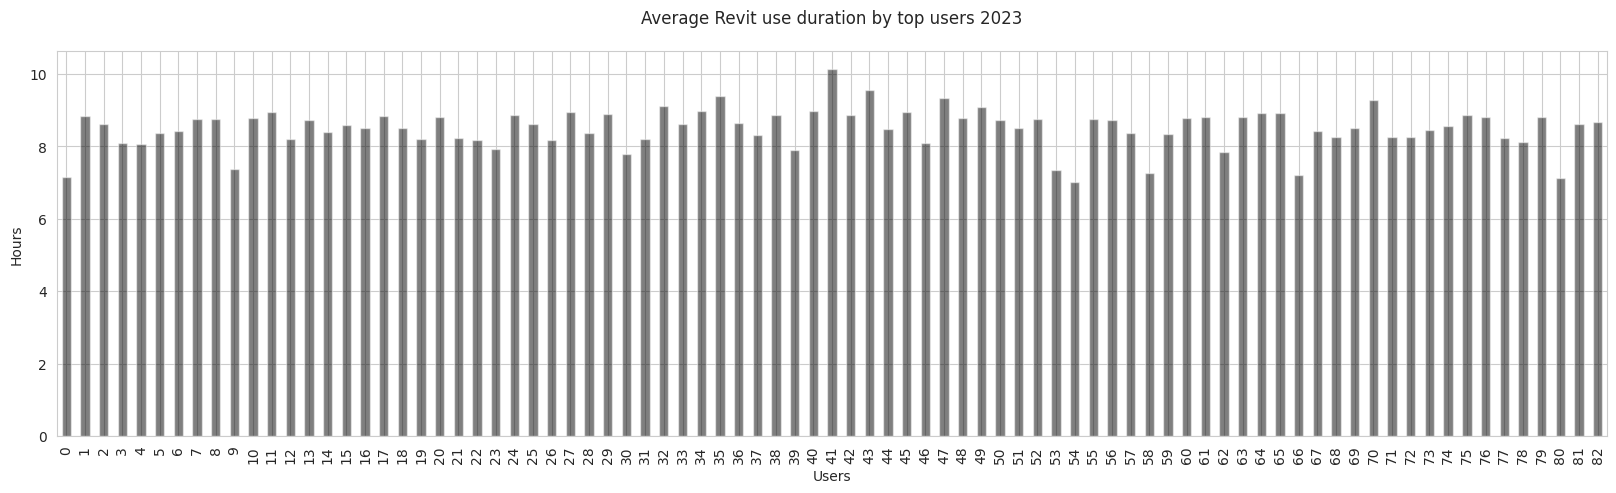

In [115]:
final_report_top_users['median'].plot(kind='bar',
                            figsize=(20, 5),
                            grid = True,
                            color='k',
                            alpha=0.5

);
plt.title('Average Revit use duration by top users 2023', pad = 20)
plt.xlabel('Users')
plt.ylabel('Hours')
plt.show();

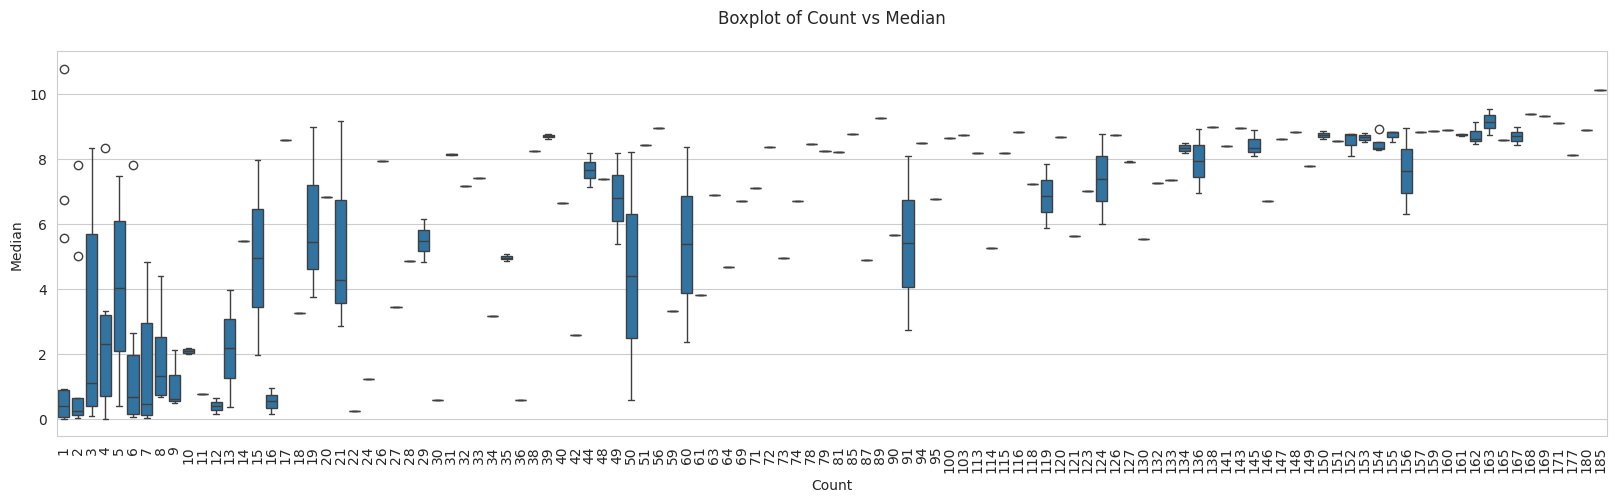

In [135]:
f, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(x='count', y='median', data=final_report, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Boxplot of Count vs Median', pad=20)
ax.set_xlabel('Count')
ax.set_ylabel('Median')

plt.show()

In [117]:
corr = final_report['median'].corr(final_report['count'])

In [118]:
print(f'There is a correlation of {round(corr*100)}% between the avg. time work and frequenty of entries.')

There is a correlation of 73% between the avg. time work and frequenty of entries.


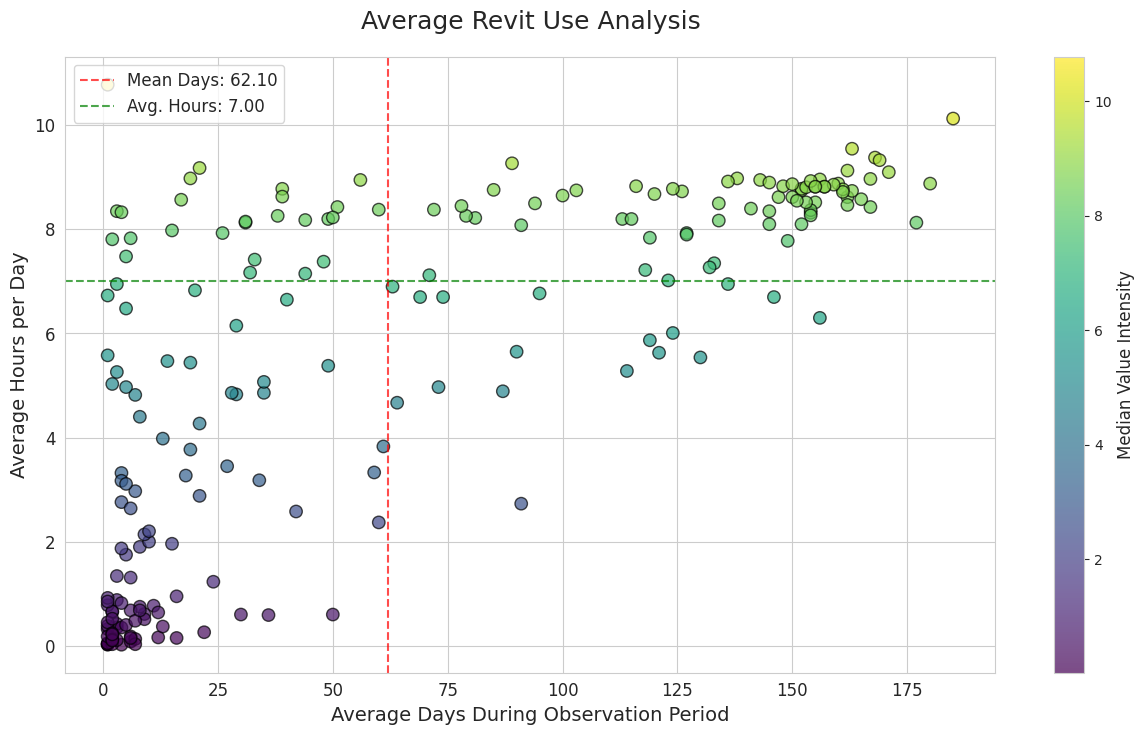

In [140]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(15, 8))
scatter = ax.scatter(
    x=final_report['count'],
    y=final_report['median'],
    c=final_report['median'],
    cmap='viridis',
    s=80,
    alpha=0.7,
    edgecolor='k'
)
cbar = plt.colorbar(scatter)
cbar.set_label('Median Value Intensity', fontsize=12)

mean_days_count = final_report['count'].mean()
mean_hours = final_report['median'].mean()
ax.axvline(x=mean_days_count, color='red', linestyle='--', alpha=0.7, label=f'Mean Days: {mean_days_count:.2f}')
ax.axhline(y=7, color='green', linestyle='--', alpha=0.7, label=f'Avg. Hours: {7:.2f}')

ax.set_title('Average Revit Use Analysis', fontsize=18, pad=20)
ax.set_xlabel('Average Days During Observation Period', fontsize=14)
ax.set_ylabel('Average Hours per Day', fontsize=14)

ax.legend(loc='upper left', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

It would be great to add the following information:

- Role of the employee: We could observe a pattern of usage for different project roles.
- Project stage: We are currently working in 2D during LP5 (details). To make an informed decision about the license, it would be helpful to see whether statistics for each user depend on the project stage.

Next steps:

- Collect more data on license usage.
- Make hourly or daily predictions, which were probably more relevant when we used a package solution.